# Subspace Inference

Bayesian inference methods generate uncertainty information in Neural Networks (DNN). However, using Bayesian inference in Deep Neural network is challenging due to the large dimension of parameter space. The subspace inference method is used to generate uncertainty information of DNN parameters subspace.

Subspace Inference package is implemented based on the following publication:

Izmailov, P., Maddox, W. J., Kirichenko, P., Garipov, T., Vetrov, D., & Wilson, A. G. (2020, August). Subspace inference for Bayesian deep learning. In Uncertainty in Artificial Intelligence (pp. 1169-1179). PMLR.

### Subspace Inference package can be installed by using the following commands:
```julia
using Pkg
Pkg.add(url = "https://github.com/efmanu/SubspaceInference.jl.git")
```

### This notebook contains uncertainty generation of simple multilayer perceptron
The is DNN contains two inputs and one output. The hidden layer sizes are as follows [200 50 50]

Start using subspace inference using in Julia.

In [1]:
#use packages

using NPZ
using Plots
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using Plots
using BSON: @save
using BSON: @load
using Zygote
using Statistics
using Revise
using SubspaceInference

┌ Info: Precompiling SubspaceInference [706446a6-0e85-4c47-b731-c658bbb72625]
└ @ Base loading.jl:1278


### Set root of project folder
This folder contains data and trained networks.

In [2]:
root = pwd();
cd(root);

### Plot Data
This loaded data conatains two columns, one is taken as <em>x</em> and <em>y</em>. The <em>x</em>  is converted to features using <em>features</em> function. Then zipped using <em>DataLoader</em> available with <em>Flux</em>

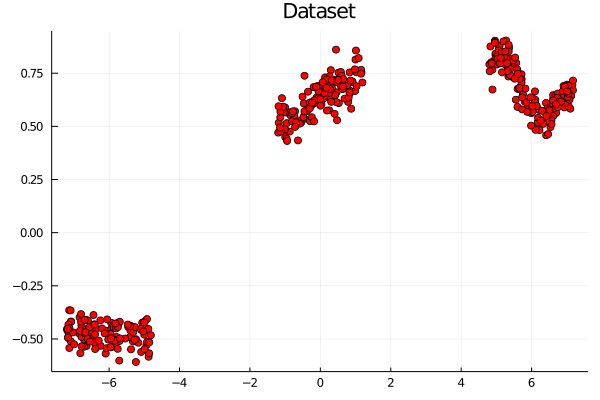

In [3]:
#laod data
data_ld = npzread("data.npy");
x, y = (data_ld[:, 1]', data_ld[:, 2]');
function features(x)
    return vcat(x./2, (x./2).^2)
end

f = features(x);
data =  DataLoader(f,y, batchsize=50, shuffle=true);

#plot data
scatter(data_ld[:,1],data_ld[:,2],color=["red"], title="Dataset", legend=false)

### DNN Model setup
The simple multilayer perceptron is created as using Dense layer. This DNN contains 2 inputs, 1 output and hidden layers of [200,50,50] size. All layers other than the output layer contains the ***ReLu*** activation function.

In [4]:
m = Chain(
		Dense(2,200,Flux.relu), 
		Dense(200,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,1),
	)

Chain(Dense(2, 200, relu), Dense(200, 50, relu), Dense(50, 50, relu), Dense(50, 50, relu), Dense(50, 1))

The model is destructed to extract weights and function as below

In [5]:
θ, re = Flux.destructure(m);

### Cost function
Gaussian likelihood cost function is implemented for training as:

In [6]:
L(x, y) = Flux.Losses.mse(m(x), y)/2;

The parameters are loaded as:

In [7]:
ps = Flux.params(m);

### Optimizer
The optimizer used in this project is Stochastic gradient descent with momentum value:

In [8]:
opt = Momentum(0.01, 0.95);

### Pretrain weights ad save
The DNN needs to pre-train and save for subspace inference as below. NB: training takes little time. This package examples contain some trained weights.

In [9]:
# epochs = 3000
# for j in 1:5
#    m = Chain(
#            Dense(2,200,Flux.relu),
#            Dense(200,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,1),
#    )
#    ps = Flux.params(m)
#    SubspaceInference.pretrain(epochs, L, ps, data, opt, lr_init =0.01, print_freq= 100)
#    @save "model_weights_$(j).bson" ps
# end

### Plot different SGD solutions

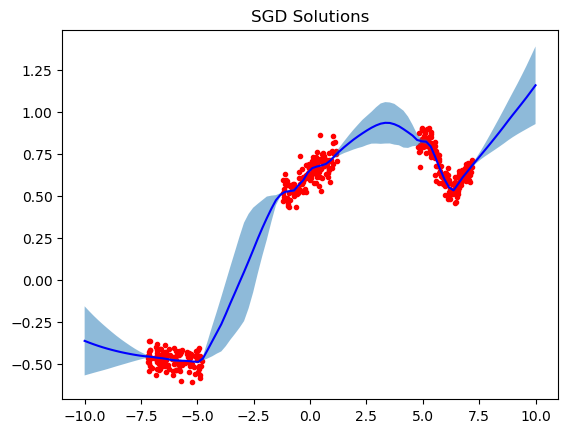

In [10]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,5)
for i in 1:5
	@load "model_weights_$(i).bson" ps
	Flux.loadparams!(m, ps)
	out = m(inp)
	trajectories[:, i] = out'
end
all_trj = Dict()
all_trj["1"] = trajectories
SubspaceInference.plot_predictive(data_ld, all_trj, z, title=["SGD Solutions"])


### Load pre-trained weight
The pre-trained weights can be found in the examples folder.

In [ ]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

### Generate uncertainty of weights using
The <em>weight_uncertainty</em> function from the ***SubspaceInference*** package is used to generate parameter space uncertainty

In [ ]:
M = 10 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = 100, T=10, M=10)


### Plot uncertainty using different trajectories that generated using PCA with NUTS

In [ ]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end
all_trajectories = Dict()
all_trajectories["1"] = trajectories
SubspaceInference.plot_predictive(data_ld, trajectories, z, title=["With PCA and NUTS"])

### PCA with HMC

In [ ]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)
i = 1
@load "model_weights_$(i).bson" ps
Flux.loadparams!(m, ps)

M = 10
T = 10
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, 
	prior_dist = Normal(0.0,10.0), σ_l = 10.0, alg = HMC(0.65,5), 
	itr = 100, T=10, M=10)

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and HMC")

## Comparion of uncertainty generation using different samplers
The uncertainty is generated with subspace having size of 2,6,10 and 20. Moreover, Bayesian inference is conducted for 1000 and 10000 times. The prior distribution is selected with Noraml distribution having mean `0.0` and standard deviation `10.0`.

### Subspace Size: 2

In [ ]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)



M = 2 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
all_trajectories = Dict()

itr = 1000

In [ ]:

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

#For MH with 1000 iterations
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["1"] = trajectories


In [ ]:

#For NUTS with 1000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);


all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["2"] = trajectories

In [ ]:

#For MH with 10000 iterations

itr = 10000
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["3"] = trajectories

In [ ]:
#For NUTS with 10000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["4"] = trajectories

In [ ]:
title = ["MH with 1000 itr", "NUTS with 1000 itr", "MH with 10000 itr", "NUTS with 10000 itr"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)

### Subspace Size: 6

In [ ]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)



M = 6 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
all_trajectories = Dict()

itr = 1000

In [ ]:
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

#For MH with 1000 iterations
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["1"] = trajectories

In [ ]:

#For NUTS with 1000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);


all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["2"] = trajectories

In [ ]:

#For MH with 10000 iterations

itr = 10000
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["3"] = trajectories

In [ ]:

#For NUTS with 10000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["4"] = trajectories

In [ ]:
title = ["MH with 1000 itr", "NUTS with 1000 itr", "MH with 10000 itr", "NUTS with 10000 itr"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)

### Subspace 10

In [ ]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)



M = 10 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
all_trajectories = Dict()

itr = 1000

In [ ]:
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

#For MH with 1000 iterations
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["1"] = trajectories

In [ ]:
#For NUTS with 1000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);


all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["2"] = trajectories

In [ ]:
#For MH with 10000 iterations

itr = 10000
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["3"] = trajectories

In [ ]:
#For NUTS with 10000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["4"] = trajectories

In [ ]:
title = ["MH with 1000 itr", "NUTS with 1000 itr", "MH with 10000 itr", "NUTS with 10000 itr"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)

### Subspace 20

In [ ]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)



M = 20 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
all_trajectories = Dict()

itr = 1000

In [ ]:
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

#For MH with 1000 iterations
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["1"] = trajectories

In [ ]:
#For NUTS with 1000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);


all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["2"] = trajectories

In [ ]:
#For MH with 10000 iterations

itr = 10000
k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= MH(), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["3"] = trajectories

In [ ]:
#For NUTS with 10000 iterations

k = 1;
@load "model_weights_$(k).bson" ps;
Flux.loadparams!(m, ps);

all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = itr, T=10, M=M, print_freq = T, alg= NUTS(0.65), prior_dist = Normal(0.0,10.0))


trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

all_trajectories["4"] = trajectories

In [ ]:
title = ["MH with 1000 itr", "NUTS with 1000 itr", "MH with 10000 itr", "NUTS with 10000 itr"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)